**Deep Learning - CSE4006**
# LAB 11
> ## Name: **K CHARVI**
> ## Reg No: 19BCE7002
> ## Date: 12|11|2021
> ## Submitted To: Dr. BKSP Kumarraju Alluri


# Brain Tumor Classification

## Categories: No Tumor, Pituitary Tumor, Glioma Tumor, Meningioma Tumor

### Cloning repository for dataset

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

/content/drive/MyDrive
Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 11.78 MiB/s, done.
Checking out files: 100% (3264/3264), done.


### Importing Necessary Libraries

In [ ]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

### Data Preparation

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 74/74 [00:00<00:00, 88.66it/s]


### Show sample images from each label

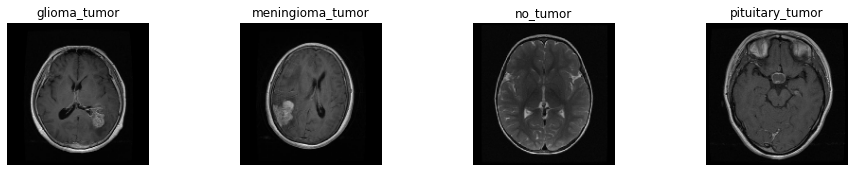

In [ ]:
plt.figure(figsize=(16, 12))
import matplotlib.image as mpimg
path = '/content/drive/MyDrive/Brain-Tumor-Classification-DataSet/'
fileNames = ['Training/glioma_tumor/gg (10).jpg', 'Training/meningioma_tumor/m (108).jpg', 'Training/no_tumor/image (16).jpg', 'Training/pituitary_tumor/p (12).jpg']
fileLabels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for i in range(4):
    ax = plt.subplot(4, 4, i +1)
    img = mpimg.imread(path + fileNames[i])
    img = cv2.resize(img, (150, 150))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

### Shuffling the train set

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=28)

In [ ]:
X_train.shape

(2870, 150, 150, 3)

#### Showing the counts of observations in each categorical bin using bars

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


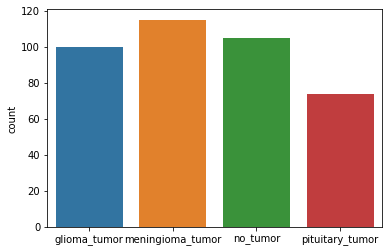

In [ ]:
sns.countplot(Y_test)

### One-Hot encoding

In [ ]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

### Split the data into training and validation subsets

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)

### Transfer Learning with EfficientNetB2

In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

31801344/31790344 [==============================] - 0s 0us/step


In [ ]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Defining  Callbacks to save efficient model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=10,
zoom_range=0.2,
width_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

### Training the Model

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=10, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.9024
Epoch 00001: val_accuracy improved from -inf to 0.89024, saving model to brain_tumor_classification.h5
72/72 [==============================] - 40s 551ms/step - loss: 0.2833 - accuracy: 0.9024 - val_loss: 0.7186 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9368
Epoch 00002: val_accuracy improved from 0.89024 to 0.90767, saving model to brain_tumor_classification.h5
72/72 [==============================] - 38s 531ms/step - loss: 0.1785 - accuracy: 0.9368 - val_loss: 0.4213 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9434
Epoch 00003: val_accuracy improved from 0.90767 to 0.94425, saving model to brain_tumor_classification.h5
72/72 [==============================] - 37s 518ms/step - loss: 0.1616 - accuracy: 0.9434 - val_loss: 0.2530 - va

In [ ]:
!pwd

/content/drive/MyDrive


### Evaluate the model

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 78.68%


### Export the model to TFLITE

In [ ]:
new_model = tf.keras.models.load_model('./brain_tumor_classification.h5')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open("model_19bce7002_trial2.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi6nehg8q/assets


30803592